In [ ]:
from google.colab import files
uploaded = files.upload()

Saving levelmain.csv to levelmain.csv
Saving regionA.csv to regionA.csv
Saving regionB.csv to regionB.csv
Saving regionC.csv to regionC.csv


In [ ]:
import numpy as np
import tensorflow as tf
import random

# Random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

# Set the random seeds
set_seeds(42)

In [ ]:
import pandas as pd
# Load Data
level_data = pd.read_csv('levelmain.csv', usecols=['date', 'level'])
region_a_data = pd.read_csv('regionA.csv', usecols=['date', 'precipitation', 'temp','rHum', 'soilMoisture'])
region_b_data = pd.read_csv('regionB.csv', usecols=['date', 'precipitation', 'temp','rHum', 'soilMoisture'])
region_c_data = pd.read_csv('regionC.csv', usecols=['date', 'precipitation', 'temp','rHum', 'soilMoisture'])

In [ ]:
#Rename columns to indicate regions
region_a_data.rename(columns={
    'precipitation': 'regionA_rainfall',
    'temp': 'regionA_temperature',
    'rHum': 'regionA_humidity',
    'soilMoisture': 'regionA_soil_moisture'
}, inplace=True)

region_b_data.rename(columns={
    'precipitation': 'regionB_rainfall',
    'temp': 'regionB_temperature',
    'rHum': 'regionB_humidity',
    'soilMoisture': 'regionB_soil_moisture'
}, inplace=True)

region_c_data.rename(columns={
    'precipitation': 'regionC_rainfall',
    'temp': 'regionC_temperature',
    'rHum': 'regionC_humidity',
    'soilMoisture': 'regionC_soil_moisture'
}, inplace=True)

In [ ]:
#Convert 'date' column to datetime and handle parsing errors
level_data['date'] = pd.to_datetime(level_data['date'], dayfirst=True, errors='coerce')
region_a_data['date'] = pd.to_datetime(region_a_data['date'], dayfirst=True, errors='coerce')
region_b_data['date'] = pd.to_datetime(region_b_data['date'], dayfirst=True, errors='coerce')
region_c_data['date'] = pd.to_datetime(region_c_data['date'], dayfirst=True, errors='coerce')

<ipython-input-5-64b8bc94593c>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  level_data['date'] = pd.to_datetime(level_data['date'], dayfirst=True, errors='coerce')


In [ ]:
#Aggregate river level data to daily averages
level_data = level_data.groupby('date').mean().reset_index()

In [ ]:
#Check for missing values in the 'level'
missing_values_count = level_data['level'].isnull().sum()
print(f"Missing values in 'level': {missing_values_count}")

Missing values in 'level': 0


In [ ]:
# Check for missing dates in river levels
full_date_range = pd.date_range(start=level_data['date'].min(), end=level_data['date'].max(), freq='D')
missing_dates = full_date_range.difference(level_data['date'])
print(f"Missing dates: {len(missing_dates)}")

Missing dates: 865


In [ ]:
# Reindex the data to include all dates
level_data = level_data.set_index('date').reindex(full_date_range).rename_axis('date').reset_index()

In [ ]:
from scipy.interpolate import PchipInterpolator
# Interpolate missing river level values using PCHIP
level_data['level'] = PchipInterpolator(
    level_data.dropna()['date'].astype(int) / 10**9,
    level_data.dropna()['level']
)(level_data['date'].astype(int) / 10**9)

In [ ]:
#Merge all dataframes on 'date'
merged_data = level_data.merge(region_a_data, on='date', how='inner')
merged_data = merged_data.merge(region_b_data, on='date', how='inner')
merged_data = merged_data.merge(region_c_data, on='date', how='inner')

In [ ]:
#Filter out river levels above 4 meters
filtered_data = merged_data[merged_data['level'] <= 4.0]

In [ ]:
import pandas as pd

new_features = {}

# Create lagged features for river levels
for lag in range(1, 8):  # Lag from 1 to 7 days
    new_features[f'level_lag_{lag}'] = filtered_data['level'].shift(lag)

# Create lagged features for weather and soil parameters from each station
stations = ['regionA', 'regionB', 'regionC']
for station in stations:
    for lag in range(1, 8):  # Lag from 1 to 7 days
        new_features[f'{station}_rainfall_lag_{lag}'] = filtered_data[f'{station}_rainfall'].shift(lag)
        new_features[f'{station}_temperature_lag_{lag}'] = filtered_data[f'{station}_temperature'].shift(lag)
        new_features[f'{station}_humidity_lag_{lag}'] = filtered_data[f'{station}_humidity'].shift(lag)
        new_features[f'{station}_soil_moisture_lag_{lag}'] = filtered_data[f'{station}_soil_moisture'].shift(lag)

# Create cumulative features for rainfall, humidity, and soil moisture
for station in stations:
    for window in [3, 5, 7]:
        new_features[f'{station}_rainfall_cumulative_{window}'] = (
            filtered_data[f'{station}_rainfall'].rolling(window=window).sum()
        )
        new_features[f'{station}_humidity_cumulative_{window}'] = (
            filtered_data[f'{station}_humidity'].rolling(window=window).sum()
        )
        new_features[f'{station}_soil_moisture_cumulative_{window}'] = (
            filtered_data[f'{station}_soil_moisture'].rolling(window=window).sum()
        )

# Convert new features dictionary to DataFrame
new_features_df = pd.DataFrame(new_features)

# Concatenate the new features with the original DataFrame
filtered_data = pd.concat([filtered_data, new_features_df], axis=1)

In [ ]:
#Drop rows with NaN values due to lagging and rolling operations
filtered_data.dropna(inplace=True)

In [ ]:
filtered_data.index

Index([    7,     8,     9,    10,    11,    12,    13,    14,    15,    16,
       ...
       13869, 13870, 13871, 13872, 13873, 13874, 13875, 13876, 13877, 13878],
      dtype='int64', length=13849)

In [ ]:
filtered_data.set_index('date', inplace=True)


In [ ]:
print("Filtered data index type:", filtered_data.index.dtype)


Filtered data index type: datetime64[ns]


In [ ]:
#Define feature columns for training
feature_columns = [col for col in filtered_data.columns if col.startswith('regionA') or col.startswith('regionB') or col.startswith('regionC') or col.startswith('level_lag_')]

In [ ]:
#Define X and y
X = filtered_data[feature_columns]
y = filtered_data['level']

In [ ]:
split_index = int(0.8 * len(filtered_data))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Extract test dates
test_dates = filtered_data.index[split_index:]
print("Test dates range:", test_dates.min(), "to", test_dates.max())


Test dates range: 2012-05-25 00:00:00 to 2019-12-31 00:00:00


In [ ]:
# Display the shapes of the datasets for verification
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

X_train shape: (11079, 130), X_test shape: (2770, 130)
y_train shape: (11079,), y_test shape: (2770,)


In [ ]:
filtered_data.shape

(13849, 131)

In [ ]:
filtered_data.head()

,level,regionA_temperature,regionA_humidity,regionA_rainfall,regionA_soil_moisture,regionB_temperature,regionB_humidity,regionB_rainfall,regionB_soil_moisture,regionC_temperature,...,regionB_soil_moisture_cumulative_7,regionC_rainfall_cumulative_3,regionC_humidity_cumulative_3,regionC_soil_moisture_cumulative_3,regionC_rainfall_cumulative_5,regionC_humidity_cumulative_5,regionC_soil_moisture_cumulative_5,regionC_rainfall_cumulative_7,regionC_humidity_cumulative_7,regionC_soil_moisture_cumulative_7
date,,,,,,,,,,,,,,,,,,,,,
1982-01-08,0.87,17.54,78.06,1.80,0.56,23.76,59.19,0.69,0.49,25.05,...,3.50,2.10,174.69,1.47,2.57,294.44,2.45,3.83,427.37,3.43
1982-01-09,0.87,16.37,86.31,4.14,0.56,21.54,72.56,3.39,0.49,23.05,...,3.48,5.16,184.81,1.47,5.56,303.25,2.45,6.23,426.37,3.43
1982-01-10,0.87,17.11,80.12,1.76,0.56,21.80,68.81,0.73,0.49,24.02,...,3.46,4.57,190.12,1.47,6.26,307.12,2.45,6.73,426.87,3.43
1982-01-11,0.85,17.60,80.69,10.04,0.56,21.97,72.06,10.62,0.50,23.94,...,3.46,13.04,200.05,1.47,14.87,315.05,2.45,15.27,433.49,3.43
1982-01-12,0.85,17.76,82.38,7.16,0.57,22.69,72.00,7.06,0.51,24.32,...,3.47,16.05,199.05,1.48,19.79,326.55,2.46,21.48,443.55,3.44


Data Normalization:


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))



```
```

Reshaping for cnnlstm

In [ ]:
# Extract station-related features and river level features
stations = 3
features_per_station = 41
lagged_river_features = 7
time_steps = 1  # Pre-encoded temporal dependencies


In [ ]:
# Display the feature column names to verify the order
print(X.columns.tolist())

['regionA_temperature', 'regionA_humidity', 'regionA_rainfall', 'regionA_soil_moisture', 'regionB_temperature', 'regionB_humidity', 'regionB_rainfall', 'regionB_soil_moisture', 'regionC_temperature', 'regionC_humidity', 'regionC_rainfall', 'regionC_soil_moisture', 'level_lag_1', 'level_lag_2', 'level_lag_3', 'level_lag_4', 'level_lag_5', 'level_lag_6', 'level_lag_7', 'regionA_rainfall_lag_1', 'regionA_temperature_lag_1', 'regionA_humidity_lag_1', 'regionA_soil_moisture_lag_1', 'regionA_rainfall_lag_2', 'regionA_temperature_lag_2', 'regionA_humidity_lag_2', 'regionA_soil_moisture_lag_2', 'regionA_rainfall_lag_3', 'regionA_temperature_lag_3', 'regionA_humidity_lag_3', 'regionA_soil_moisture_lag_3', 'regionA_rainfall_lag_4', 'regionA_temperature_lag_4', 'regionA_humidity_lag_4', 'regionA_soil_moisture_lag_4', 'regionA_rainfall_lag_5', 'regionA_temperature_lag_5', 'regionA_humidity_lag_5', 'regionA_soil_moisture_lag_5', 'regionA_rainfall_lag_6', 'regionA_temperature_lag_6', 'regionA_humidi

In [ ]:
# Identify index ranges
direct_station_features = X.columns[:12]  # First 12 columns
lagged_river_features = X.columns[12:19]  # Next 7 columns for river levels
lagged_station_features = X.columns[19:103]  # Next 84 columns
cumulative_station_features = X.columns[103:]  # Last 27 columns

# Validate total features
total_features = len(direct_station_features) + len(lagged_river_features) + len(lagged_station_features) + len(cumulative_station_features)
print(f"Total Features: {total_features}")


Total Features: 130


In [ ]:
station_features_train = X_train_scaled[:, :len(direct_station_features) + len(lagged_station_features) + len(cumulative_station_features)]
station_features_test = X_test_scaled[:, :len(direct_station_features) + len(lagged_station_features) + len(cumulative_station_features)]

In [ ]:
river_features_train = X_train_scaled[:, len(direct_station_features):len(direct_station_features) + len(lagged_river_features)]
river_features_test = X_test_scaled[:, len(direct_station_features):len(direct_station_features) + len(lagged_river_features)]


In [ ]:
# Reshape station features
station_features_train_reshaped = station_features_train.reshape(
    (station_features_train.shape[0], time_steps, stations, features_per_station)
)
station_features_test_reshaped = station_features_test.reshape(
    (station_features_test.shape[0], time_steps, stations, features_per_station)
)

# Confirm shapes
print(f"Station Features Train Reshaped Shape: {station_features_train_reshaped.shape}")
print(f"Station Features Test Reshaped Shape: {station_features_test_reshaped.shape}")

Station Features Train Reshaped Shape: (11079, 1, 3, 41)
Station Features Test Reshaped Shape: (2770, 1, 3, 41)


In [ ]:
# Repeat river features for each station
river_features_train_repeated = np.repeat(river_features_train[:, np.newaxis, np.newaxis, :], stations, axis=2)
river_features_test_repeated = np.repeat(river_features_test[:, np.newaxis, np.newaxis, :], stations, axis=2)

# Verify shapes
print(f"River Features Train Repeated Shape: {river_features_train_repeated.shape}")
print(f"River Features Test Repeated Shape: {river_features_test_repeated.shape}")


River Features Train Repeated Shape: (11079, 1, 3, 7)
River Features Test Repeated Shape: (2770, 1, 3, 7)


In [ ]:
# Concatenate station features and repeated river features
station_features_train_combined = np.concatenate(
    [station_features_train_reshaped, river_features_train_repeated], axis=3
)
station_features_test_combined = np.concatenate(
    [station_features_test_reshaped, river_features_test_repeated], axis=3
)

# Verify the shapes
print(f"Training Data Combined Shape: {station_features_train_combined.shape}")
print(f"Test Data Combined Shape: {station_features_test_combined.shape}")


Training Data Combined Shape: (11079, 1, 3, 48)
Test Data Combined Shape: (2770, 1, 3, 48)


CNNLSTM1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout

# Define the CNN-LSTM model
def create_cnn_lstm_model(input_shape):
    model = Sequential()

    # TimeDistributed CNN to process spatial relationships
    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))
    model.add(TimeDistributed(Flatten()))

    # LSTM layer to process temporal dependencies
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.3))

    # Fully connected output layer for regression
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
input_shape = (1, 3, 48, 1)  # (time_steps, stations, features, channels)


In [ ]:
cnn_lstm_model = create_cnn_lstm_model(input_shape)
cnn_lstm_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 1, 3, 46, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 1, 3, 23, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 1, 4416)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │         893,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 893,707 (3.41 MB)

 Trainable params: 893,707 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Add a channel dimension for Conv2D
station_features_train_combined = station_features_train_combined[..., np.newaxis]
station_features_test_combined = station_features_test_combined[..., np.newaxis]

# Verify the final shapes
print(f"Training Data Shape with Channel: {station_features_train_combined.shape}")
print(f"Test Data Shape with Channel: {station_features_test_combined.shape}")


Training Data Shape with Channel: (11079, 1, 3, 48, 1)
Test Data Shape with Channel: (2770, 1, 3, 48, 1)


In [ ]:
history = cnn_lstm_model.fit(
    station_features_train_combined, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(station_features_test_combined, y_test_scaled),
    verbose=1
)

# Evaluate the model
loss = cnn_lstm_model.evaluate(station_features_test_combined, y_test_scaled, verbose=0)
print(f"Test Loss: {loss}")


Epoch 1/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0065 - val_loss: 0.0030
Epoch 2/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 3/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 4/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 5/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 6/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 7/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 8/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 9/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 10/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 11/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 12/50
347/347 ━━━━━━━━━━━━━━━━━━

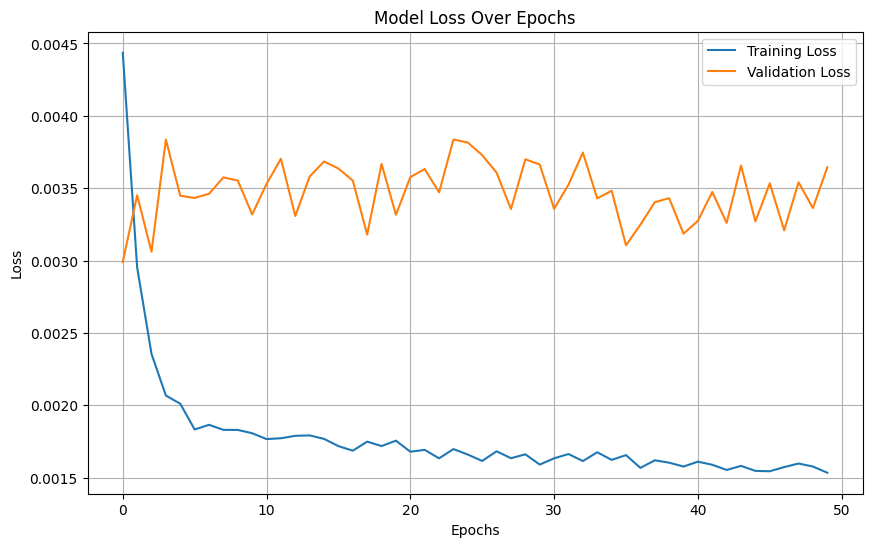

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the history object
plot_loss(history)


In [ ]:
# Make predictions
y_pred_scaled = cnn_lstm_model.predict(station_features_test_combined)

# Inverse transform predictions and actual values
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_original = y_scaler.inverse_transform(y_test_scaled)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE
mae = mean_absolute_error(y_test_original, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.1526
Root Mean Squared Error (RMSE): 0.2415


model1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout

def create_model1(input_shape):
    model1 = Sequential()

    # TimeDistributed CNN to process spatial relationships
    model1.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1, 5), activation='relu'), input_shape=input_shape))
    model1.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))
    model1.add(TimeDistributed(Flatten()))

    # LSTM layer with increased units
    model1.add(LSTM(100, activation='relu'))
    model1.add(Dropout(0.4))  # Increased dropout rate

    # Fully connected output layer for regression
    model1.add(Dense(1))

    # Compile the model
    model1.compile(optimizer='adam', loss='mean_squared_error')
    return model1


In [ ]:
model1 = create_model1(input_shape)
model1.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_3 (TimeDistributed) │ (None, 1, 3, 44, 128)       │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 1, 3, 22, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 1, 8448)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │       3,419,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,420,469 (13.05 MB)

 Trainable params: 3,420,469 (13.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train Model1
history_model1 = model1.fit(
    station_features_train_combined, y_train_scaled,
    epochs=50, batch_size=32,  # Adjust if needed
    validation_data=(station_features_test_combined, y_test_scaled),
    verbose=1
)


Epoch 1/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - loss: 0.0084 - val_loss: 0.0033
Epoch 2/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 3/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 4/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 5/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 6/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 7/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 8/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 9/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 10/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 11/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 12/50
347/347 ━━━━━━━━━━

In [ ]:
# Make predictions with Model1
y_pred_scaled_model1 = model1.predict(station_features_test_combined)

# Inverse transform predictions
y_pred_model1 = y_scaler.inverse_transform(y_pred_scaled_model1)

# Calculate MAE and RMSE for Model1
mae_model1 = mean_absolute_error(y_test_original, y_pred_model1)
rmse_model1 = np.sqrt(mean_squared_error(y_test_original, y_pred_model1))

print(f"Model1 - Mean Absolute Error (MAE): {mae_model1:.4f}")
print(f"Model1 - Root Mean Squared Error (RMSE): {rmse_model1:.4f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Model1 - Mean Absolute Error (MAE): 0.1314
Model1 - Root Mean Squared Error (RMSE): 0.2207


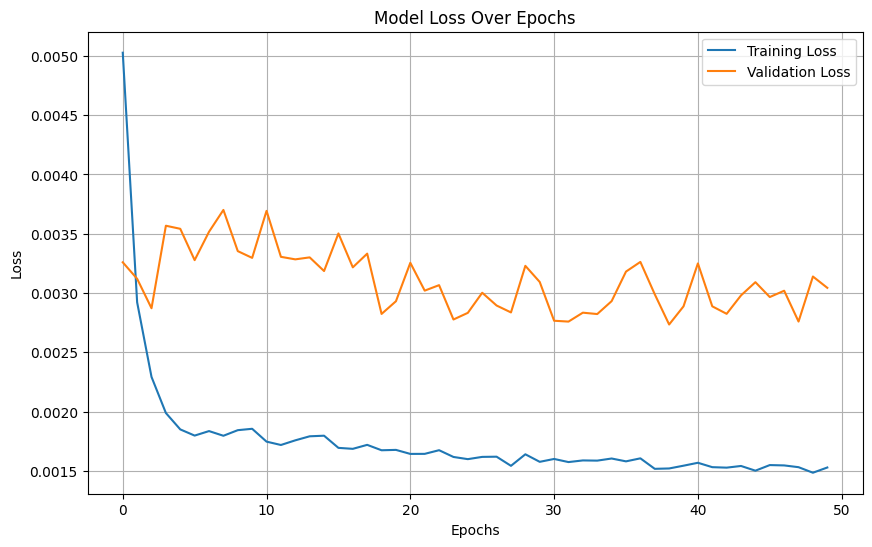

In [ ]:
# Plot loss curves for Model1
plot_loss(history_model1)


model2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization

def create_model2(input_shape):
    model2 = Sequential()

    # TimeDistributed CNN with Batch Normalization
    model2.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1, 5), activation='relu'), input_shape=input_shape))
    model2.add(TimeDistributed(BatchNormalization()))
    model2.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))
    model2.add(TimeDistributed(Flatten()))

    # LSTM with Batch Normalization
    model2.add(LSTM(100, activation='relu', return_sequences=False))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.4))  # Regularization to avoid overfitting

    # Fully connected output layer for regression
    model2.add(Dense(1))

    # Compile the model
    model2.compile(optimizer='adam', loss='mean_squared_error')
    return model2


In [ ]:
model2 = create_model2(input_shape)
model2.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_7 (TimeDistributed) │ (None, 1, 3, 44, 128)       │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 1, 3, 44, 128)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 1, 3, 22, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 1, 8448)             │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │       3,419,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,421,381 (13.05 MB)

 Trainable params: 3,420,925 (13.05 MB)

 Non-trainable params: 456 (1.78 KB)

In [ ]:
history_model2 = model2.fit(
    station_features_train_combined, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(station_features_test_combined, y_test_scaled),
    verbose=1
)


Epoch 1/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - loss: 0.4159 - val_loss: 0.0237
Epoch 2/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - loss: 0.0223 - val_loss: 0.0050
Epoch 3/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 4/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 6/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 43s 80ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 7/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 10/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 11/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 12/50
347/347 ━━━━━━━━━━

In [ ]:
# Make predictions with Model3
y_pred_scaled_model2 = model2.predict(station_features_test_combined)

# Inverse transform predictions
y_pred_model2 = y_scaler.inverse_transform(y_pred_scaled_model2)

# Calculate MAE and RMSE for Model3
mae_model2 = mean_absolute_error(y_test_original, y_pred_model2)
rmse_model2 = np.sqrt(mean_squared_error(y_test_original, y_pred_model2))

print(f"Model3 - Mean Absolute Error (MAE): {mae_model2:.4f}")
print(f"Model3 - Root Mean Squared Error (RMSE): {rmse_model2:.4f}")


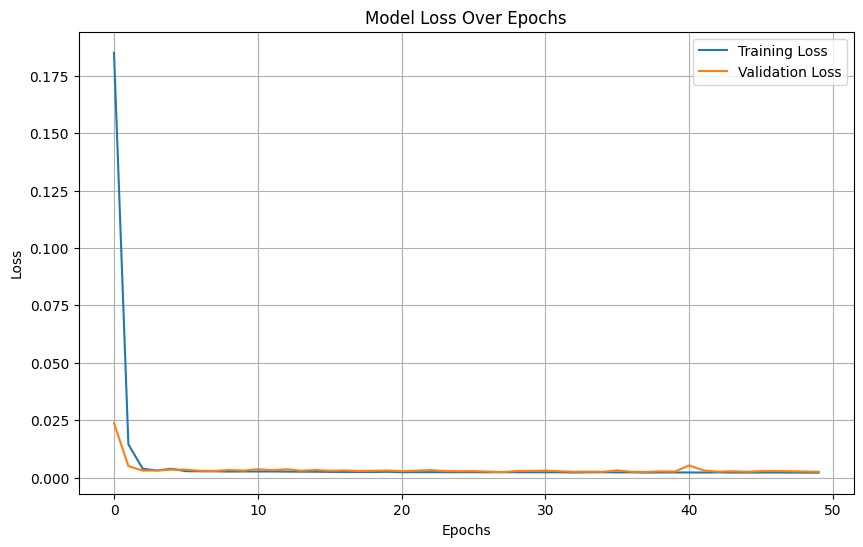

In [ ]:
plot_loss(history_model2)


model3

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

def create_model3(input_shape):
    model3 = Sequential()

    # TimeDistributed CNN with Batch Normalization
    model3.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1, 5), activation='relu'), input_shape=input_shape))
    model3.add(TimeDistributed(BatchNormalization()))
    model3.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))
    model3.add(TimeDistributed(Flatten()))

    # LSTM with Batch Normalization
    model3.add(LSTM(100, activation='relu', return_sequences=False))
    model3.add(BatchNormalization())
    model3.add(Dropout(0.4))  # Regularization to avoid overfitting

    # Fully connected output layer for regression
    model3.add(Dense(1))

    # Compile the model
    model3.compile(optimizer='adam', loss='mean_squared_error')
    return model3


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
model3 = create_model3(input_shape)
model3.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_10                  │ (None, 1, 3, 44, 128)       │             768 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 1, 3, 44, 128)       │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 1, 3, 22, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 1, 8448)             │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100)                 │       3,419,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,421,381 (13.05 MB)

 Trainable params: 3,420,925 (13.05 MB)

 Non-trainable params: 456 (1.78 KB)

In [ ]:
history_model3 = model3.fit(
    station_features_train_combined, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(station_features_test_combined, y_test_scaled),
    callbacks=[lr_scheduler],  # Add the scheduler as a callback
    verbose=1
)


Epoch 1/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - loss: 0.3477 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 2/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - loss: 0.0216 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 3/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - loss: 0.0042 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 4/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - loss: 0.0032 - val_loss: 0.0338 - learning_rate: 0.0010
Epoch 5/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - loss: 0.0030 - val_loss: 0.0398 - learning_rate: 0.0010
Epoch 6/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - loss: 0.0029 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 7/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0028
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
347/347 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - loss: 0.0028 - val_loss: 0.0399 - learning_rate: 0.0010
Epoch 8/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 39s 70ms/step - loss: 0.0026 - val_loss: 0.

In [ ]:
# Make predictions with Model3
y_pred_scaled_model3 = model3.predict(station_features_test_combined)

# Inverse transform predictions
y_pred_model3 = y_scaler.inverse_transform(y_pred_scaled_model3)

# Calculate MAE and RMSE for Model3
mae_model3 = mean_absolute_error(y_test_original, y_pred_model3)
rmse_model3 = np.sqrt(mean_squared_error(y_test_original, y_pred_model3))

print(f"Model3 - Mean Absolute Error (MAE): {mae_model3:.4f}")
print(f"Model3 - Root Mean Squared Error (RMSE): {rmse_model3:.4f}")


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Model3 - Mean Absolute Error (MAE): 0.0875
Model3 - Root Mean Squared Error (RMSE): 0.1911


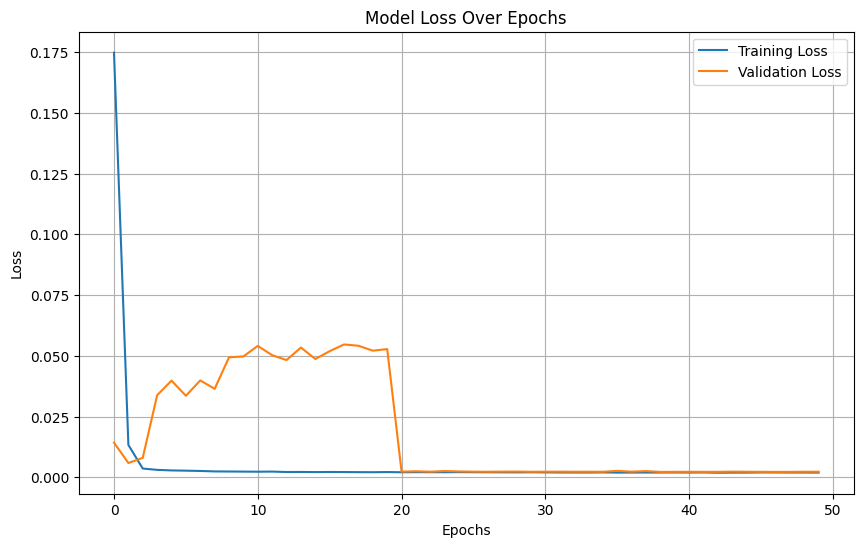

In [ ]:
plot_loss(history_model3)


model4

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

def create_model4(input_shape):
    model4 = Sequential()

    # TimeDistributed CNN with L2 Regularization
    model4.add(TimeDistributed(
        Conv2D(filters=128, kernel_size=(1, 5), activation='relu',
               kernel_regularizer=l2(0.01)),  # L2 Regularization
        input_shape=input_shape
    ))
    model4.add(TimeDistributed(BatchNormalization()))
    model4.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))
    model4.add(TimeDistributed(Flatten()))

    # LSTM with L2 Regularization
    model4.add(LSTM(100, activation='relu', return_sequences=False, kernel_regularizer=l2(0.01)))
    model4.add(BatchNormalization())
    model4.add(Dropout(0.4))

    # Fully connected output layer with L2 Regularization
    model4.add(Dense(1, kernel_regularizer=l2(0.01)))

    # Compile the model
    model4.compile(optimizer='adam', loss='mean_squared_error')
    return model4


In [ ]:
model4 = create_model4(input_shape)
model4.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_3 (TimeDistributed) │ (None, 1, 3, 44, 128)       │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 1, 3, 44, 128)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 1, 3, 22, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 1, 8448)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │       3,419,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,421,381 (13.05 MB)

 Trainable params: 3,420,925 (13.05 MB)

 Non-trainable params: 456 (1.78 KB)

In [ ]:
history_model4 = model4.fit(
    station_features_train_combined, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(station_features_test_combined, y_test_scaled),
    verbose=1
)


Epoch 1/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - loss: 3.2961 - val_loss: 0.4029
Epoch 2/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 39s 101ms/step - loss: 0.2762 - val_loss: 0.1116
Epoch 3/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - loss: 0.0657 - val_loss: 0.0351
Epoch 4/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - loss: 0.0261 - val_loss: 0.0197
Epoch 5/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - loss: 0.0165 - val_loss: 0.0143
Epoch 6/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - loss: 0.0114 - val_loss: 0.0136
Epoch 7/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 8/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 9/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 10/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - loss: 0.0045 - val_loss: 0.0049
Epoch 11/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 12/50
347/347

In [ ]:
# Make predictions with Model4
y_pred_scaled_model4 = model4.predict(station_features_test_combined)

# Inverse transform predictions
y_pred_model4 = y_scaler.inverse_transform(y_pred_scaled_model4)

# Calculate MAE and RMSE for Model4
mae_model4 = mean_absolute_error(y_test_original, y_pred_model4)
rmse_model4 = np.sqrt(mean_squared_error(y_test_original, y_pred_model4))

print(f"Model4 - Mean Absolute Error (MAE): {mae_model4:.4f}")
print(f"Model4 - Root Mean Squared Error (RMSE): {rmse_model4:.4f}")


87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
Model4 - Mean Absolute Error (MAE): 0.0926
Model4 - Root Mean Squared Error (RMSE): 0.2135


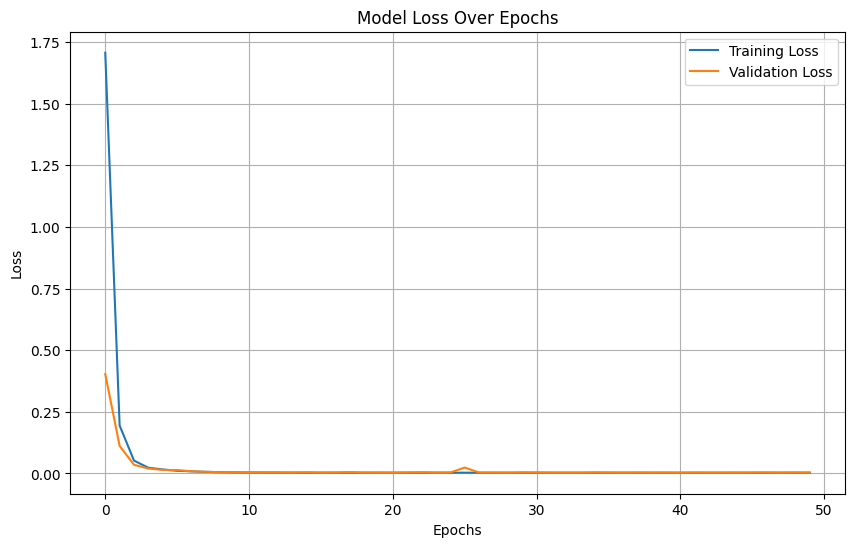

In [ ]:
plot_loss(history_model4)


model5

In [ ]:
from tensorflow.keras.layers import Dense, Multiply

def simplified_attention(inputs):
    # Calculate attention scores
    attention_scores = Dense(inputs.shape[-1], activation='softmax')(inputs)
    # Apply the scores to the inputs
    weighted_inputs = Multiply()([inputs, attention_scores])
    return weighted_inputs


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization

def create_model5(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # TimeDistributed CNN
    cnn = TimeDistributed(Conv2D(filters=128, kernel_size=(1, 5), activation='relu'))(inputs)
    cnn = TimeDistributed(BatchNormalization())(cnn)
    cnn = TimeDistributed(MaxPooling2D(pool_size=(1, 2)))(cnn)
    cnn = TimeDistributed(Flatten())(cnn)

    # LSTM layer
    lstm_out = LSTM(100, activation='relu', return_sequences=True)(cnn)

    # Simplified Attention Mechanism
    attention_out = simplified_attention(lstm_out)

    # Fully connected layers
    dropout = Dropout(0.4)(attention_out)
    dense = Dense(1)(dropout)

    # Define the model
    model5 = Model(inputs=inputs, outputs=dense)
    model5.compile(optimizer='adam', loss='mean_squared_error')
    return model5


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
model5 = create_model5(input_shape)
model5.summary()

# Train the model with callbacks
history_model5 = model5.fit(
    station_features_train_combined, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(station_features_test_combined, y_test_scaled),
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 1, 3, 48, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_22       │ (None, 1, 3, 44, 128)  │            768 │ input_layer_6[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_23       │ (None, 1, 3, 44, 128)  │            512 │ time_distributed_22[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_24       │ (None, 1, 3, 22, 128)  │              0 │ time_distributed_23[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_25       │ (None, 1, 8448)        │              0 │ time_distributed_24[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 1, 100)         │      3,419,600 │ time_distributed_25[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1, 100)         │         10,100 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 1, 100)         │              0 │ lstm_6[0][0],          │
│                           │                        │                │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 1, 100)         │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1, 1)           │            101 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,431,081 (13.09 MB)

 Trainable params: 3,430,825 (13.09 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - loss: 0.0168 - val_loss: 0.0308 - learning_rate: 0.0010
Epoch 2/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - loss: 0.0036 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 3/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - loss: 0.0026 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 44s 80ms/step - loss: 0.0022 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 5/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - loss: 0.0021 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 6/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - loss: 0.0021 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - loss: 0.0020 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 8/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0023
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
347/347 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - loss: 0.0023 - val_loss: 0.

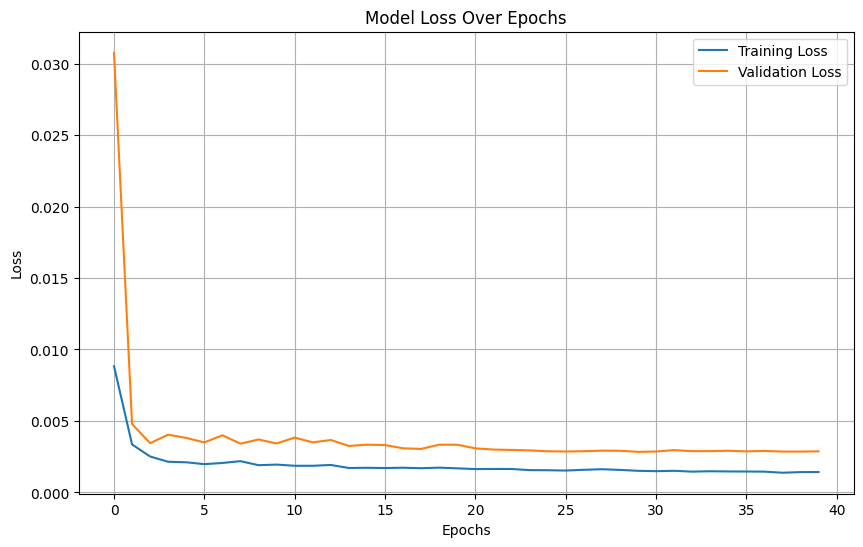

In [ ]:
plot_loss(history_model5)


In [ ]:
# Make predictions with Model5
y_pred_scaled_model5 = model5.predict(station_features_test_combined)

# Reshape predictions to 2D
y_pred_scaled_model5_reshaped = y_pred_scaled_model5.reshape(-1, 1)

# Inverse transform predictions
y_pred_model5 = y_scaler.inverse_transform(y_pred_scaled_model5_reshaped)

# Calculate MAE and RMSE
mae_model5 = mean_absolute_error(y_test_original, y_pred_model5)
rmse_model5 = np.sqrt(mean_squared_error(y_test_original, y_pred_model5))

print(f"Model5 - Mean Absolute Error (MAE): {mae_model5:.4f}")
print(f"Model5 - Root Mean Squared Error (RMSE): {rmse_model5:.4f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Model5 - Mean Absolute Error (MAE): 0.1332
Model5 - Root Mean Squared Error (RMSE): 0.2131


High variability

In [ ]:
# Define high variability periods from the test data
high_variability_periods = [
    ('2012-05-25', '2012-05-31'),
    ('2012-10-01', '2012-12-31'),
    ('2013-03-01', '2013-05-31'),
    ('2013-10-01', '2013-12-31'),
    ('2014-03-01', '2014-05-31'),
    ('2014-10-01', '2014-12-31'),
    ('2015-03-01', '2015-05-31'),
    ('2015-10-01', '2015-12-31'),
    ('2016-03-01', '2016-05-31'),
    ('2016-10-01', '2016-12-31'),
    ('2017-03-01', '2017-05-31'),
    ('2017-10-01', '2017-12-31'),
    ('2018-03-01', '2018-05-31'),
    ('2018-10-01', '2018-12-31'),
    ('2019-03-01', '2019-05-31'),
    ('2019-10-01', '2019-12-31')
]

In [ ]:
X_test.head()

,regionA_temperature,regionA_humidity,regionA_rainfall,regionA_soil_moisture,regionB_temperature,regionB_humidity,regionB_rainfall,regionB_soil_moisture,regionC_temperature,regionC_humidity,...,regionB_soil_moisture_cumulative_7,regionC_rainfall_cumulative_3,regionC_humidity_cumulative_3,regionC_soil_moisture_cumulative_3,regionC_rainfall_cumulative_5,regionC_humidity_cumulative_5,regionC_soil_moisture_cumulative_5,regionC_rainfall_cumulative_7,regionC_humidity_cumulative_7,regionC_soil_moisture_cumulative_7
date,,,,,,,,,,,,,,,,,,,,,
2012-05-25,16.37,84.25,1.29,0.65,20.19,77.50,0.94,0.56,22.25,73.25,...,4.02,2.08,215.37,1.62,2.76,355.18,2.72,2.88,490.99,3.82
2012-05-26,16.65,80.25,0.84,0.64,20.58,74.88,0.55,0.56,22.59,71.06,...,3.99,2.41,213.93,1.62,3.35,357.93,2.71,3.76,493.80,3.81
2012-05-27,16.19,84.56,3.98,0.64,19.87,78.94,2.77,0.56,21.68,76.62,...,3.97,7.21,220.93,1.62,8.10,363.05,2.70,8.78,502.86,3.80
2012-05-28,16.35,82.94,2.44,0.64,20.23,76.75,1.79,0.56,22.09,75.19,...,3.95,9.42,222.87,1.62,10.90,365.74,2.70,11.84,509.74,3.79
2012-05-29,16.14,81.88,0.96,0.64,20.03,75.94,0.69,0.55,22.01,73.44,...,3.93,9.47,225.25,1.62,11.59,369.56,2.70,12.48,511.68,3.78


In [ ]:
def evaluate_model_on_high_variability(model, x_data, y_data, periods, dates, scaler):

    dates = pd.to_datetime(dates)

    # Create a boolean mask for high variability periods
    mask = np.zeros(len(dates), dtype=bool)
    for start, end in periods:
        mask |= (dates >= start) & (dates <= end)

    # Filter x_data and y_data using the mask
    x_filtered = x_data[mask]
    y_filtered = y_data[mask]

    # Ensure reshaping of x_filtered for model input
    x_filtered = x_filtered.reshape(-1, 1, 3, 48, 1)

    # Predict on filtered data
    predictions = model.predict(x_filtered)

    # Flatten predictions and true values
    predictions = predictions.flatten()
    y_filtered = y_filtered.flatten()

    # Inverse transform predictions and true values
    predictions_original = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    y_filtered_original = scaler.inverse_transform(y_filtered.reshape(-1, 1)).flatten()

    # Evaluate metrics in original scale
    mae = mean_absolute_error(y_filtered_original, predictions_original)
    rmse = np.sqrt(mean_squared_error(y_filtered_original, predictions_original))

    return mae, rmse, predictions_original, y_filtered_original


In [ ]:
results = []
all_predictions = {}

for model, name in zip(models, model_names):
    mae, rmse, predictions_original, y_filtered_original = evaluate_model_on_high_variability(
        model=model,
        x_data=station_features_test_combined,
        y_data=y_test_scaled,
        periods=high_variability_periods,
        dates=dates_test,
        scaler=y_scaler
    )
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse})
    all_predictions[name] = {'Predictions': predictions_original, 'True Values': y_filtered_original}

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)
print(results_df)



optimizing

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import keras_tuner as kt
import tensorflow as tf

# Define the model builder
def model_builder(hp):
    model6 = Sequential()

    # TimeDistributed CNN with hyperparameters
    model6.add(TimeDistributed(
        Conv2D(
            filters=hp.Int('filters', min_value=64, max_value=256, step=32),
            kernel_size=(1, hp.Choice('kernel_size', values=[3, 5])),
            activation='relu',
            kernel_regularizer=l2(hp.Choice('l2', values=[0.01, 0.001, 0.0001]))
        ),
        input_shape=(1, 3, 48, 1)
    ))
    model6.add(TimeDistributed(BatchNormalization()))
    model6.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))
    model6.add(TimeDistributed(Flatten()))

    # LSTM with hyperparameters
    model6.add(LSTM(
        units=hp.Int('lstm_units', min_value=50, max_value=200, step=50),
        activation='relu',
        return_sequences=False,
        kernel_regularizer=l2(hp.Choice('l2_lstm', values=[0.01, 0.001, 0.0001]))
    ))
    model6.add(BatchNormalization())
    model6.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Fully connected output layer
    model6.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=l2(hp.Choice('l2_dense', values=[0.01, 0.001, 0.0001]))
    ))
    model6.add(Dropout(hp.Float('dropout_dense', min_value=0.2, max_value=0.5, step=0.1)))
    model6.add(Dense(1))

    # Compile the model
    model6.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='mean_squared_error'
    )

    return model6

# Initialize the tuner
tuner = kt.Hyperband(
    hypermodel=model_builder,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='model6_hyperparameter_optimization'
)

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search
tuner.search(
    station_features_train_combined, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(station_features_test_combined, y_test_scaled),
    callbacks=[stop_early],
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal hyperparameters:
Filters: {best_hps.get('filters')},
Kernel size: {best_hps.get('kernel_size')},
LSTM units: {best_hps.get('lstm_units')},
Dropout: {best_hps.get('dropout')},
Dense units: {best_hps.get('dense_units')},
Optimizer: {best_hps.get('optimizer')}.
""")

# Build and train the model with the best hyperparameters
best_model6 = tuner.hypermodel.build(best_hps)
history_model6 = best_model6.fit(
    station_features_train_combined, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(station_features_test_combined, y_test_scaled),
    callbacks=[stop_early],
    verbose=1
)

Trial 88 Complete [00h 13m 20s]
val_loss: 0.0044420575723052025

Best val_loss So Far: 0.002770619699731469
Total elapsed time: 05h 55m 16s

Search: Running Trial #89

Value             |Best Value So Far |Hyperparameter
192               |96                |filters
5                 |3                 |kernel_size
0.001             |0.0001            |l2
100               |100               |lstm_units
0.01              |0.001             |l2_lstm
0.3               |0.2               |dropout
64                |128               |dense_units
0.001             |0.0001            |l2_dense
0.3               |0.3               |dropout_dense
adam              |rmsprop           |optimizer
50                |50                |tuner/epochs
0                 |17                |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - loss: 2.6689 - val_loss: 0.2998
Epoc

KeyboardInterrupt: 

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found so far:")
print(best_hps.values)


Best hyperparameters found so far:
{'filters': 96, 'kernel_size': 3, 'l2': 0.0001, 'lstm_units': 100, 'l2_lstm': 0.001, 'dropout': 0.2, 'dense_units': 128, 'l2_dense': 0.0001, 'dropout_dense': 0.30000000000000004, 'optimizer': 'rmsprop', 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0071'}


In [ ]:
# Build the best model
best_model6 = tuner.hypermodel.build(best_hps)

# Train the model
history_model6 = best_model6.fit(
    station_features_train_combined, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(station_features_test_combined, y_test_scaled),
    verbose=1
)

# Save the best model for future use
best_model6.save('optimized_model6.h5')


Epoch 1/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 0.6115 - val_loss: 0.0483
Epoch 2/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 0.0267 - val_loss: 0.0188
Epoch 3/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0101 - val_loss: 0.0126
Epoch 4/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.0076 - val_loss: 0.0133
Epoch 5/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0057 - val_loss: 0.0111
Epoch 6/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - loss: 0.0048 - val_loss: 0.0089
Epoch 7/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 8/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 9/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 10/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 11/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 12/50
347/347 ━━━━━━━━━━

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate the best model on the full test set
def evaluate_model_full_test(model, X_test, y_test, scaler):

    # Make predictions
    predictions_scaled = model.predict(X_test)

    # Inverse transform predictions and true values
    predictions_original = scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Evaluate metrics
    mae = mean_absolute_error(y_test_original, predictions_original)
    rmse = np.sqrt(mean_squared_error(y_test_original, predictions_original))

    return mae, rmse, predictions_original, y_test_original

# Evaluate the best model on high variability periods
def evaluate_model_high_variability(model, X_test, y_test, periods, dates, scaler):

    # Ensure dates are in datetime format
    dates = pd.to_datetime(dates)

    # Create a boolean mask for high variability periods
    mask = np.zeros(len(dates), dtype=bool)  # Initialize mask
    for start, end in periods:
        mask |= (dates >= start) & (dates <= end)

    # Filter X_test and y_test using the mask
    X_filtered = X_test[mask]
    y_filtered = y_test[mask]

    # Predict on filtered data
    predictions_scaled = model.predict(X_filtered)

    # Inverse transform predictions and true values
    predictions_original = scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
    y_filtered_original = scaler.inverse_transform(y_filtered.reshape(-1, 1)).flatten()

    # Evaluate metrics
    mae = mean_absolute_error(y_filtered_original, predictions_original)
    rmse = np.sqrt(mean_squared_error(y_filtered_original, predictions_original))

    return mae, rmse, predictions_original, y_filtered_original


In [ ]:
# Full Test Set Evaluation
mae_full, rmse_full, predictions_full, y_test_full = evaluate_model_full_test(
    model=best_model6,
    X_test=station_features_test_combined,
    y_test=y_test_scaled,
    scaler=y_scaler
)

print(f"Full Test Set Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_full:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_full:.4f}\n")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Full Test Set Evaluation Metrics:
Mean Absolute Error (MAE): 0.0919
Root Mean Squared Error (RMSE): 0.2116



In [ ]:
dates_test = pd.date_range(start='2012-01-01', periods=station_features_test_combined.shape[0], freq='D')

mae_hv, rmse_hv, predictions_hv, y_test_hv = evaluate_model_high_variability(
    model=best_model6,
    X_test=station_features_test_combined,
    y_test=y_test_scaled,
    periods=high_variability_periods,
    dates=dates_test,
    scaler=y_scaler
)

print(f"High Variability Periods Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_hv:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_hv:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
High Variability Periods Evaluation Metrics:
Mean Absolute Error (MAE): 0.1302
Root Mean Squared Error (RMSE): 0.2916
